# SVM Tuning (Descriptors)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem, RDLogger
from rdkit.Chem import Descriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.ML.Descriptors import MoleculeDescriptors as md
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    RandomizedSearchCV,
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    classification_report,
)

from sklearn.svm import SVC
import shap
import optuna

/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Molecule, Descriptor and Outlier Functions


In [3]:
def molecule_from_smiles(smiles):
    lg = RDLogger.logger()
    # Temporarily silence RDKit logs (Only critical)
    lg.setLevel(RDLogger.CRITICAL)
    try:
        # Extract molecule
        molecule = Chem.MolFromSmiles(smiles, sanitize=True)
        if molecule is None:
            return None, "failed"

        # Remove salts
        clean_molecule = rdMolStandardize.LargestFragmentChooser()
        molecule = clean_molecule.choose(molecule)

        # Sanitize molecule again to reflect changes
        Chem.SanitizeMol(molecule)
        return molecule, "succeed"
    except Exception as e:
        return None, f"error: {e}"
    finally:
        # re-enable logging afterward
        lg.setLevel(RDLogger.INFO)


def calculate_descriptors(molecule):
    # Get all descriptors (1D/2D)
    descriptor_names = []
    for descriptor, _ in Descriptors._descList:
        descriptor_names.append(descriptor)

    # Use descriptors to calculate values
    calculator = md.MolecularDescriptorCalculator(descriptor_names)
    descriptor_values = calculator.CalcDescriptors(molecule)

    # Create dictionary
    descriptors = dict(zip(descriptor_names, descriptor_values))
    return descriptors


def compute_iqr_limits(df, factor=1.5):
    # Calculate IQR limits
    limits = {}
    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        # If IQR is 0 - column is too flat - skip
        if iqr == 0 or np.isnan(iqr):
            continue

        lower = q1 - factor * iqr
        upper = q3 + factor * iqr
        limits[col] = (lower, upper)
    return limits


def apply_iqr_limits(df, limits):
    # Apply the limits
    df_clipped = df.copy()
    for col, (lower, upper) in limits.items():
        df_clipped[col] = df_clipped[col].clip(lower, upper)
    return df_clipped

## Dataset Processing


In [ ]:
# Configuration
ORIG_DATASET = "in_chemico_dataset.xlsx"
SKIP_ROWS = 1
SMILES_COL = "SMILES code"
TARGET_COL = "Phototoxicity"
FULL_OUTPUT_DATASET = "in_chemico_dataset_processed.xlsx"

# Outputs
TRAIN_X_CSV = "in_chemico_x_train.csv"
TEST_X_CSV = "in_chemico_x_test.csv"
TRAIN_Y_CSV = "in_chemico_y_train.csv"
TEST_Y_CSV = "in_chemico_y_test.csv"

# Near constant threshold - tolerance
SIMILARITY_THRESHOLD = 0.80
# Correlation threshold
CORRELATION_THRESHOLD = 0.90

# Load dataset and skip first row (Header)
dataset = pd.read_excel(ORIG_DATASET, engine="openpyxl", skiprows=SKIP_ROWS)

# Build descriptors
descriptor_rows = []
state_molecules = []
molecules = []

# Loop over the SMILES column
for smiles in dataset[SMILES_COL].astype(str):
    molecule, state = molecule_from_smiles(smiles)
    state_molecules.append(state)
    molecules.append(molecule)

    # If molecule construction failed - empty placeholder
    if molecule is None:
        descriptor_rows.append({})
        continue
    # Calculate descriptors for each molecule
    descriptor_rows.append(calculate_descriptors(molecule))

# Convert list of dictionaries into dataframe
descriptor_data_all = pd.DataFrame(descriptor_rows)

# Keep everything + status
output = pd.concat(
    [dataset.reset_index(drop=True), descriptor_data_all.reset_index(drop=True)], axis=1
)
output["MoleculeStatus"] = state_molecules

# Output whole dataset with descriptors and state
with pd.ExcelWriter(FULL_OUTPUT_DATASET, engine="openpyxl") as writer:
    output.to_excel(writer, index=False, sheet_name="Descriptors")

print(f"Full - Rows: {len(output)}/Columns: {output.shape[1]}")
print(output.head().to_string(index=False))

# Drop failed molecules - boolean array
molecules_right = []
for molecule in molecules:
    if molecule is not None:
        molecules_right.append(True)
    else:
        molecules_right.append(False)
if not any(molecules_right):
    raise ValueError("No valid molecules after SMILES parsing.")

dataset_ok = dataset.loc[molecules_right].reset_index(drop=True)
descriptor_ok = descriptor_data_all.loc[molecules_right].reset_index(drop=True)

# Target
y_full = dataset_ok[TARGET_COL].astype(int)

# Take only numeric descriptor columns
X_full = descriptor_ok.select_dtypes(include=[np.number]).copy()
for column in X_full.columns:
    X_full[column] = X_full[column].replace([np.inf, -np.inf], np.nan)

# Drop columns that are entirely NaN
all_nan_cols = X_full.columns[X_full.isna().all()].tolist()
if all_nan_cols:
    print(f"Dropping {len(all_nan_cols)} NaN columns.")
    X_full = X_full.drop(columns=all_nan_cols)

# Split dataset - train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# Calculate medians for each column in train only
train_medians = X_train.median(numeric_only=True)

# Fill missing values in both train and test using those medians
X_train = X_train.fillna(train_medians)
X_test = X_test.fillna(train_medians)

# Compute constants on train only
constant_cols = []
for col in X_train.columns:
    top_freq = X_train[col].value_counts(normalize=True, dropna=False).max()
    if top_freq >= SIMILARITY_THRESHOLD:
        constant_cols.append(col)

# Drop from train and apply same drop to test
if constant_cols:
    X_train = X_train.drop(columns=constant_cols)
    X_test = X_test.drop(columns=constant_cols)
    print(f"Dropped {len(constant_cols)} constant/almost-constant columns.")

# Compute absolute correlation matrix on training data
corr_matrix = X_train.corr().abs()
# Keep only upper triangle of the matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find columns to drop - correlation
high_corr_cols = []
for col in upper.columns:
    if any(upper[col] > CORRELATION_THRESHOLD):
        high_corr_cols.append(col)

# Drop from both train and test
if high_corr_cols:
    X_train = X_train.drop(columns=high_corr_cols)
    X_test = X_test.drop(columns=high_corr_cols)
    print(f"Dropped {len(high_corr_cols)} highly correlated columns.")

# Compute IQR limits on training data
iqr_limits = compute_iqr_limits(X_train, factor=1.5)

# Apply limits to both train and test sets
X_train = apply_iqr_limits(X_train, iqr_limits)
X_test = apply_iqr_limits(X_test, iqr_limits)

# Scaling not necessary for all models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

X_train.to_csv(TRAIN_X_CSV, index=False)
X_test.to_csv(TEST_X_CSV, index=False)
y_train.to_csv(TRAIN_Y_CSV, index=False, header=[TARGET_COL])
y_test.to_csv(TEST_Y_CSV, index=False, header=[TARGET_COL])

print(f"Train - Rows: {len(X_train)}/Columns: {X_train.shape[1]}")
print("First rows of train x:")
print(X_train.head().to_string(index=False))
print(f"Test - Rows: {len(X_test)}/Columns: {X_test.shape[1]}")
print("First rows of train y:")
print(y_train.head().to_string(index=False))
X_train.describe()

print("\nTrain set class counts:")
print(y_train.value_counts())
print("\nTrain set class ratio:")
print(y_train.value_counts(normalize=True))

print("\nTest set class counts:")
print(y_test.value_counts())
print("\nTest set class ratio:")
print(y_test.value_counts(normalize=True))

Full - Rows: 162/Columns: 230
                          Name                                                                                              IUPAC name CAS registry number    Structure  Phototoxicity                                                      SMILES code                            Sources               Note    Unnamed: 8 Unnamed: 9  Unnamed: 10 Unnamed: 11  MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex      qed       SPS   MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  NumRadicalElectrons  MaxPartialCharge  MinPartialCharge  MaxAbsPartialCharge  MinAbsPartialCharge  FpDensityMorgan1  FpDensityMorgan2  FpDensityMorgan3  BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  BCUT2D_CHGLO  BCUT2D_LOGPHI  BCUT2D_LOGPLOW  BCUT2D_MRHI  BCUT2D_MRLOW   AvgIpc  BalabanJ    BertzCT      Chi0     Chi0n     Chi0v      Chi1    Chi1n    Chi1v    Chi2n    Chi2v    Chi3n    Chi3v    Chi4n    Chi4v  HallKierAlpha           Ipc    Kappa1   Kappa2   Kappa3  Labute

## Base Model Train


In [5]:
# SVM pipeline: scale features + RBF-kernel SVM with calibrated probabilities
base_model = SVC(
    kernel="rbf",
    probability=True,
    random_state=42,
)

# Train
base_model.fit(X_train, y_train)

# Predict
y_pred = base_model.predict(X_test)
y_prob = base_model.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nModel performance (SVM):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))


Model performance (SVM):
Accuracy:  0.6061
Precision: 0.6316
Recall:    0.6667
F1 score:  0.6486
ROC AUC:   0.7519

Classification report:
              precision    recall  f1-score   support

           0      0.571     0.533     0.552        15
           1      0.632     0.667     0.649        18

    accuracy                          0.606        33
   macro avg      0.602     0.600     0.600        33
weighted avg      0.604     0.606     0.605        33



## Feature Selection


PermutationExplainer explainer: 130it [00:45,  2.51it/s]                         
/tmp/ipykernel_175976/1636627740.py:31: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train)


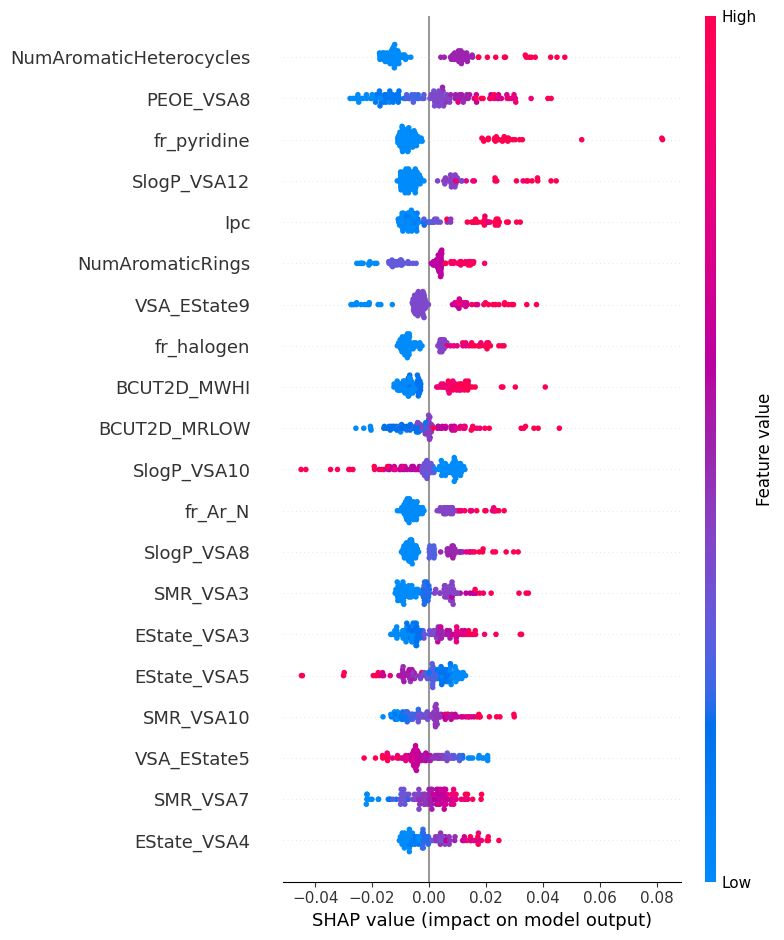


Top 10 SHAP features:
NumAromaticHeterocycles    0.014064
PEOE_VSA8                  0.013630
fr_pyridine                0.012227
SlogP_VSA12                0.009777
Ipc                        0.009535
NumAromaticRings           0.008995
VSA_EState9                0.008967
fr_halogen                 0.008858
BCUT2D_MWHI                0.008647
BCUT2D_MRLOW               0.008590

Top 10 K-Best features:
PEOE_VSA8                  27.717288
NumAromaticRings           27.301662
RingCount                  24.977419
NumAromaticHeterocycles    24.069194
AvgIpc                     22.390138
MolWt                      21.106153
SMR_VSA7                   19.921155
Ipc                        19.717393
SMR_VSA3                   19.466960
EState_VSA3                18.936294

Top 10 Lasso features:
VSA_EState9     0.960017
EState_VSA4     0.897831
PEOE_VSA3       0.805812
SlogP_VSA10     0.787073
BCUT2D_MRLOW    0.774895
BalabanJ        0.759763
PEOE_VSA2       0.754893
fr_halogen      0.74940

In [6]:
# SHAP features
# Prediction function for SHAP
f = lambda X: base_model.predict_proba(X)[:, 1]

explainer = shap.Explainer(f, X_train)
shap_result = explainer(X_train)

# Each row has values for features
shap_values = shap_result.values

# Mean absolute SHAP value per feature (importance)
shap_importance = np.abs(shap_values).mean(axis=0)
shap_features = pd.Series(shap_importance, index=X_train.columns).sort_values(
    ascending=False
)

# K-Best - Anova features
kbest = SelectKBest(score_func=f_classif, k="all")
kbest.fit(X_train, y_train)
kbest_scores = pd.Series(kbest.scores_, index=X_train.columns).fillna(0.0)
kbest_features = kbest_scores.sort_values(ascending=False)

# Lasso features
lasso = LogisticRegression(penalty="l1", C=1.0, solver="liblinear", max_iter=5000)
lasso.fit(X_train, y_train)

lasso_importance = pd.Series(np.abs(lasso.coef_).ravel(), index=X_train.columns)
lasso_features = lasso_importance.sort_values(ascending=False)

# Plot
shap.summary_plot(shap_values, X_train)

# Print best features for each method
print("\nTop 10 SHAP features:")
print(shap_features.head(10).to_string())
print("\nTop 10 K-Best features:")
print(kbest_features.head(10).to_string())
print("\nTop 10 Lasso features:")
print(lasso_features.head(10).to_string())

## SHAP Features



CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.728923  0.751665    0.792766
1      6     0.721231  0.745397    0.808791
2      7     0.714462  0.739440    0.796795
3      8     0.706769  0.732434    0.790842
4      9     0.706769  0.731277    0.794414

Best number of features by CV F1: 5
Top_N          5.000000
CV_Accuracy    0.728923
CV_F1          0.751665
CV_ROC_AUC     0.792766
Name: 0, dtype: float64


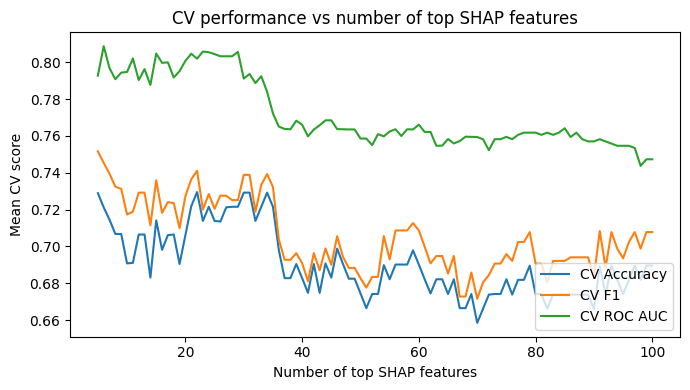

In [ ]:
# results = []

# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Evaluate from top 5 features up to all
# for n in range(5, len(shap_features) + 1):
#     top_feats = shap_features.head(n).index

#     # model = xgb.XGBClassifier(
#     #     objective="binary:logistic", eval_metric=["logloss", "auc"], random_state=42
#     # )
#     model = SVC(
#         kernel="rbf",
#         probability=True,
#         random_state=42,
#     )

#     # Cross validation
#     cv_res = cross_validate(
#         model,
#         X_train[top_feats],
#         y_train,
#         cv=kf,
#         scoring={"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"},
#         n_jobs=-1,
#         return_train_score=False,
#     )

#     mean_acc = cv_res["test_accuracy"].mean()
#     mean_f1 = cv_res["test_f1"].mean()
#     mean_auc = cv_res["test_roc_auc"].mean()

#     results.append((n, mean_acc, mean_f1, mean_auc))

# # Results DataFrame
# res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# # Pick best N by CV F1
# best = res_df.iloc[res_df["CV_F1"].idxmax()]
# best_n = int(best.Top_N)
# best_n_shap = int(best.Top_N)

# print("\nCV results (training only, mean over folds):")
# print(res_df.head())
# print(f"\nBest number of features by CV F1: {best_n}")
# print(best)

# # Plot CV performance
# plt.figure(figsize=(7, 4))
# plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
# plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
# plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
# plt.xlabel("Number of top SHAP features")
# plt.ylabel("Mean CV score")
# plt.title("CV performance vs number of top SHAP features")
# plt.legend(loc="lower right")
# plt.tight_layout()
# plt.show()

## KBEST Features



CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.721538  0.741131    0.801374
1      6     0.721231  0.742547    0.808059
2      7     0.682769  0.708520    0.813004
3      8     0.706462  0.740944    0.805128
4      9     0.698462  0.738111    0.791667

Best number of features by CV F1: 6
Top_N          6.000000
CV_Accuracy    0.721231
CV_F1          0.742547
CV_ROC_AUC     0.808059
Name: 1, dtype: float64


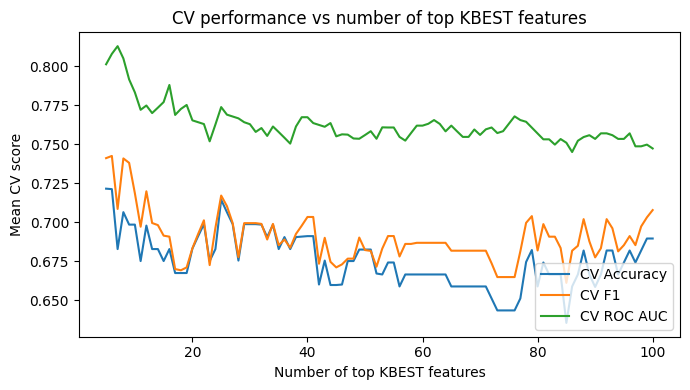

In [7]:
results = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(kbest_features) + 1):
    top_feats = kbest_features.head(n).index

    # model = xgb.XGBClassifier(
    #     objective="binary:logistic", eval_metric=["logloss", "auc"], random_state=42
    # )

    model = SVC(
        kernel="rbf",
        probability=True,
        random_state=42,
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"},
        n_jobs=-1,
        return_train_score=False,
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_kbest = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top KBEST features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top KBEST features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## LASSO Features



CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.675077  0.686619    0.715476
1      6     0.628923  0.646874    0.683425
2      7     0.620308  0.629452    0.683974
3      8     0.691077  0.720764    0.750183
4      9     0.690462  0.703982    0.752747

Best number of features by CV F1: 14
Top_N          14.000000
CV_Accuracy     0.752923
CV_F1           0.766564
CV_ROC_AUC      0.803480
Name: 9, dtype: float64


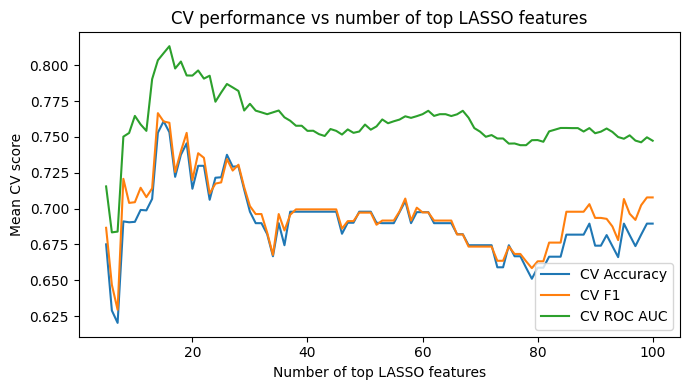

In [8]:
results = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(lasso_features) + 1):
    top_feats = lasso_features.head(n).index

    model = SVC(
        kernel="rbf",
        probability=True,
        random_state=42,
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"},
        n_jobs=-1,
        return_train_score=False,
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_lasso = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top LASSO features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top LASSO features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Model SHAP Features


In [9]:
top_feats = shap_features.head(best_n_shap).index.tolist()

# Train final model
final_model = SVC(
    kernel="rbf",
    probability=True,
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (SHAP) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (SHAP) on test:
Accuracy:  0.6667
Precision: 0.7692
Recall:    0.5556
F1 score:  0.6452
ROC AUC:   0.6926


## Model KBEST Features


In [10]:
top_feats = kbest_features.head(best_n_kbest).index.tolist()

# Train final model
final_model = SVC(
    kernel="rbf",
    probability=True,
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (KBEST) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (KBEST) on test:
Accuracy:  0.6364
Precision: 0.6875
Recall:    0.6111
F1 score:  0.6471
ROC AUC:   0.6630


## Model LASSO Features


In [11]:
top_feats = lasso_features.head(best_n_lasso).index.tolist()

# Train final model
final_model = SVC(
    kernel="rbf",
    probability=True,
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (LASSO) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (LASSO) on test:
Accuracy:  0.5758
Precision: 0.6111
Recall:    0.6111
F1 score:  0.6111
ROC AUC:   0.7000


## Model SHAP Features Tuning


In [12]:
top_feats = shap_features.head(best_n_shap).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)


# Optuna
def objective(trial):
    # ---- Optuna param space for SVM ----
    params = {
        "kernel": trial.suggest_categorical(
            "kernel", ["rbf", "linear", "poly", "sigmoid"]
        ),
        "C": trial.suggest_float("C", 1e-3, 1e3, log=True),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "shrinking": trial.suggest_categorical("shrinking", [True, False]),
        "tol": trial.suggest_float("tol", 1e-5, 1e-2, log=True),
        "max_iter": trial.suggest_categorical("max_iter", [-1, 1000, 2000]),
        "probability": True,  # needed if you evaluate with predicted probabilities (e.g., ROC AUC)
        "random_state": 42,
        "cache_size": 1000.0,
    }

    # gamma choice: allow "scale"/"auto" or a numeric value
    gamma_mode = trial.suggest_categorical("gamma_mode", ["scale", "auto", "float"])
    if gamma_mode == "float":
        params["gamma"] = trial.suggest_float("gamma", 1e-4, 10.0, log=True)
    else:
        params["gamma"] = gamma_mode

    # conditionals for poly/sigmoid
    if params["kernel"] == "poly":
        params["degree"] = trial.suggest_int("degree", 2, 5)
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    elif params["kernel"] == "sigmoid":
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    # for "rbf" and "linear" degree/coef0 are ignored, so we omit them

    # ---- Model ----
    model = SVC(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1,
    )

    return scores.mean()


# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

best_params = study.best_params.copy()

# Map gamma_mode -> gamma
gamma_mode = best_params.pop("gamma_mode", "scale")
if gamma_mode != "float":
    # 'scale' or 'auto'
    best_params["gamma"] = gamma_mode
# else: when gamma_mode == 'float', Optuna already stored a numeric 'gamma' in best_params

best_params.update(
    {
        "probability": True,  # needed for predict_proba below
        "random_state": 42,
        "cache_size": 1000.0,
    }
)

# Final model
final_model = SVC(**best_params)
final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (SHAP):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

Best trial: 0. Best value: 0.784158:   0%|          | 0/200 [00:00<?, ?it/s]/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
Best trial: 29. Best value: 0.835073:  18%|█▊        | 36/200 [00:00<00:04, 39.45it/s]/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sk


Best trial:
  Value: 0.8491758241758243
  Params:
    kernel: poly
    C: 0.125052853395494
    class_weight: None
    shrinking: True
    tol: 1.9923662360914938e-05
    max_iter: 1000
    gamma_mode: auto
    degree: 5
    coef0: 0.47020140897355134

Final Optuna model (SHAP):
Accuracy:  0.6364
Precision: 0.8000
Recall:    0.4444
F1 score:  0.5714
ROC AUC:   0.6778


## Model KBEST Features Tuning


In [13]:
top_feats = kbest_features.head(best_n_kbest).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)


# Optuna
def objective(trial):
    # Hyperparameter search space
    # ---- Optuna param space for SVM ----
    params = {
        "kernel": trial.suggest_categorical(
            "kernel", ["rbf", "linear", "poly", "sigmoid"]
        ),
        "C": trial.suggest_float("C", 1e-3, 1e3, log=True),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "shrinking": trial.suggest_categorical("shrinking", [True, False]),
        "tol": trial.suggest_float("tol", 1e-5, 1e-2, log=True),
        "max_iter": trial.suggest_categorical("max_iter", [-1, 1000, 2000]),
        "probability": True,  # needed if you evaluate with predicted probabilities (e.g., ROC AUC)
        "random_state": 42,
        "cache_size": 1000.0,
    }

    # gamma choice: allow "scale"/"auto" or a numeric value
    gamma_mode = trial.suggest_categorical("gamma_mode", ["scale", "auto", "float"])
    if gamma_mode == "float":
        params["gamma"] = trial.suggest_float("gamma", 1e-4, 10.0, log=True)
    else:
        params["gamma"] = gamma_mode

    # conditionals for poly/sigmoid
    if params["kernel"] == "poly":
        params["degree"] = trial.suggest_int("degree", 2, 5)
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    elif params["kernel"] == "sigmoid":
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    # for "rbf" and "linear" degree/coef0 are ignored, so we omit them

    # ---- Model ----
    model = SVC(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        scoring="f1",
        # scoring="roc_auc",
        n_jobs=-1,
    )

    return scores.mean()


# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")


best_params = study.best_params.copy()

# Map gamma_mode -> gamma
gamma_mode = best_params.pop("gamma_mode", "scale")
if gamma_mode != "float":
    # 'scale' or 'auto'
    best_params["gamma"] = gamma_mode
# else: when gamma_mode == 'float', Optuna already stored a numeric 'gamma' in best_params

best_params.update(
    {
        "probability": True,  # needed for predict_proba below
        "random_state": 42,
        "cache_size": 1000.0,
    }
)

# Final model
final_model = SVC(**best_params)
final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (KBEST):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

Best trial: 0. Best value: 0.724101:   0%|          | 0/200 [00:00<?, ?it/s]/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  


Best trial:
  Value: 0.790305512886158
  Params:
    kernel: poly
    C: 1.5708670920611831
    class_weight: None
    shrinking: True
    tol: 0.0011815984529228952
    max_iter: 2000
    gamma_mode: auto
    degree: 5
    coef0: 0.4159766756422541

Final Optuna model (KBEST):
Accuracy:  0.5758
Precision: 0.6111
Recall:    0.6111
F1 score:  0.6111
ROC AUC:   0.6778


## Model LASSO Features Tuning


In [14]:
top_feats = lasso_features.head(best_n_lasso).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)


# Optuna
def objective(trial):
    # ---- Optuna param space for SVM ----
    params = {
        "kernel": trial.suggest_categorical(
            "kernel", ["rbf", "linear", "poly", "sigmoid"]
        ),
        "C": trial.suggest_float("C", 1e-3, 1e3, log=True),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "shrinking": trial.suggest_categorical("shrinking", [True, False]),
        "tol": trial.suggest_float("tol", 1e-5, 1e-2, log=True),
        "max_iter": trial.suggest_categorical("max_iter", [-1, 1000, 2000]),
        "probability": True,  # needed if you evaluate with predicted probabilities (e.g., ROC AUC)
        "random_state": 42,
        "cache_size": 1000.0,
    }

    # gamma choice: allow "scale"/"auto" or a numeric value
    gamma_mode = trial.suggest_categorical("gamma_mode", ["scale", "auto", "float"])
    if gamma_mode == "float":
        params["gamma"] = trial.suggest_float("gamma", 1e-4, 10.0, log=True)
    else:
        params["gamma"] = gamma_mode

    # conditionals for poly/sigmoid
    if params["kernel"] == "poly":
        params["degree"] = trial.suggest_int("degree", 2, 5)
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    elif params["kernel"] == "sigmoid":
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    # for "rbf" and "linear" degree/coef0 are ignored, so we omit them

    # ---- Model ----
    model = SVC(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1,
    )

    return scores.mean()


# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")


best_params = study.best_params.copy()

# Map gamma_mode -> gamma
gamma_mode = best_params.pop("gamma_mode", "scale")
if gamma_mode != "float":
    # 'scale' or 'auto'
    best_params["gamma"] = gamma_mode
# else: when gamma_mode == 'float', Optuna already stored a numeric 'gamma' in best_params

best_params.update(
    {
        "probability": True,  # needed for predict_proba below
        "random_state": 42,
        "cache_size": 1000.0,
    }
)

# Final model
final_model = SVC(**best_params)
final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (LASSO):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

Best trial: 6. Best value: 0.854762:   4%|▍         | 9/200 [00:00<00:03, 59.25it/s]/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=


Best trial:
  Value: 0.8691391941391942
  Params:
    kernel: linear
    C: 1.0817272867787746
    class_weight: None
    shrinking: False
    tol: 0.005063762838877033
    max_iter: 2000
    gamma_mode: scale

Final Optuna model (LASSO):
Accuracy:  0.6364
Precision: 0.6875
Recall:    0.6111
F1 score:  0.6471
ROC AUC:   0.6926


## Model SHAP Features Tuning (Randomized Search CV)


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war


=== Testing top 5 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(7.196856730011514e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.16446761779946645), 'degree': 5, 'coef0': np.float64(0.55), 'class_weight': 'balanced', 'C': np.float64(0.014992684327860455)}
Accuracy: 0.545 | ROC-AUC: 0.715

=== Testing top 6 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(7.196856730011514e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.16446761779946645), 'degree': 5, 'coef0': np.float64(0.55), 'class_weight': 'balanced', 'C': np.float64(0.014992684327860455)}
Accuracy: 0.545 | ROC-AUC: 0.704

=== Testing top 7 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.545 | ROC-AUC: 0.352

=== Testing top 8 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.545 | ROC-AUC: 0.433

=== Testing top 9 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00868511373751352), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.014481182276745346), 'degree': 2, 'coef0': np.float64(0.65), 'class_weight': 'balanced', 'C': np.float64(0.01398713102647238)}
Accuracy: 0.545 | ROC-AUC: 0.285

=== Testing top 10 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.515 | ROC-AUC: 0.285

=== Testing top 11 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(4.094915062380427e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.004605922041145103)}
Accuracy: 0.606 | ROC-AUC: 0.696

=== Testing top 12 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.455 | ROC-AUC: 0.281

=== Testing top 13 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.455 | ROC-AUC: 0.678

=== Testing top 14 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(7.196856730011514e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.16446761779946645), 'degree': 5, 'coef0': np.float64(0.55), 'class_weight': 'balanced', 'C': np.float64(0.014992684327860455)}
Accuracy: 0.667 | ROC-AUC: 0.737

=== Testing top 15 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.455 | ROC-AUC: 0.707

=== Testing top 16 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.455 | ROC-AUC: 0.726

=== Testing top 17 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(7.196856730011514e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.16446761779946645), 'degree': 5, 'coef0': np.float64(0.55), 'class_weight': 'balanced', 'C': np.float64(0.014992684327860455)}
Accuracy: 0.636 | ROC-AUC: 0.711

=== Testing top 18 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.009658832241158708), 'degree': 5, 'coef0': np.float64(0.15000000000000002), 'class_weight': 'balanced', 'C': np.float64(0.18251834943190423)}
Accuracy: 0.545 | ROC-AUC: 0.307

=== Testing top 19 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.485 | ROC-AUC: 0.730

=== Testing top 20 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.485 | ROC-AUC: 0.763

=== Testing top 21 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.009658832241158708), 'degree': 5, 'coef0': np.float64(0.15000000000000002), 'class_weight': 'balanced', 'C': np.float64(0.18251834943190423)}
Accuracy: 0.545 | ROC-AUC: 0.267

=== Testing top 22 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.002811768697974231), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.5872786613189482), 'degree': 5, 'coef0': np.float64(0.05), 'class_weight': 'balanced', 'C': np.float64(0.12033778407775893)}
Accuracy: 0.636 | ROC-AUC: 0.741

=== Testing top 23 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.002811768697974231), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.5872786613189482), 'degree': 5, 'coef0': np.float64(0.05), 'class_weight': 'balanced', 'C': np.float64(0.12033778407775893)}
Accuracy: 0.697 | ROC-AUC: 0.763

=== Testing top 24 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.002811768697974231), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.5872786613189482), 'degree': 5, 'coef0': np.float64(0.05), 'class_weight': 'balanced', 'C': np.float64(0.12033778407775893)}
Accuracy: 0.697 | ROC-AUC: 0.770

=== Testing top 25 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.002811768697974231), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.5872786613189482), 'degree': 5, 'coef0': np.float64(0.05), 'class_weight': 'balanced', 'C': np.float64(0.12033778407775893)}
Accuracy: 0.636 | ROC-AUC: 0.756

=== Testing top 26 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.002811768697974231), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.5872786613189482), 'degree': 5, 'coef0': np.float64(0.05), 'class_weight': 'balanced', 'C': np.float64(0.12033778407775893)}
Accuracy: 0.636 | ROC-AUC: 0.765

=== Testing top 27 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00016768329368110083), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.01933891750455232), 'degree': 5, 'coef0': np.float64(0.35000000000000003), 'class_weight': 'balanced', 'C': np.float64(0.0030367711180354575)}
Accuracy: 0.545 | ROC-AUC: 0.274

=== Testing top 28 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.009658832241158708), 'degree': 5, 'coef0': np.float64(0.15000000000000002), 'class_weight': 'balanced', 'C': np.float64(0.18251834943190423)}
Accuracy: 0.545 | ROC-AUC: 0.278

=== Testing top 29 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(7.196856730011514e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.006080224261649427), 'degree': 5, 'coef0': np.float64(0.15000000000000002), 'class_weight': None, 'C': np.float64(0.03001835813575589)}
Accuracy: 0.545 | ROC-AUC: 0.767

=== Testing top 30 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.636 | ROC-AUC: 0.759

=== Testing top 31 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(7.196856730011514e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.006080224261649427), 'degree': 5, 'coef0': np.float64(0.15000000000000002), 'class_weight': None, 'C': np.float64(0.03001835813575589)}
Accuracy: 0.545 | ROC-AUC: 0.748

=== Testing top 32 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(7.196856730011514e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.006080224261649427), 'degree': 5, 'coef0': np.float64(0.15000000000000002), 'class_weight': None, 'C': np.float64(0.03001835813575589)}
Accuracy: 0.545 | ROC-AUC: 0.726

=== Testing top 33 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.636 | ROC-AUC: 0.752

=== Testing top 34 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.636 | ROC-AUC: 0.741

=== Testing top 35 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.002811768697974231), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.5872786613189482), 'degree': 5, 'coef0': np.float64(0.05), 'class_weight': 'balanced', 'C': np.float64(0.12033778407775893)}
Accuracy: 0.667 | ROC-AUC: 0.776

=== Testing top 36 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.002811768697974231), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.5872786613189482), 'degree': 5, 'coef0': np.float64(0.05), 'class_weight': 'balanced', 'C': np.float64(0.12033778407775893)}
Accuracy: 0.667 | ROC-AUC: 0.767

=== Testing top 37 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.002811768697974231), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.5872786613189482), 'degree': 5, 'coef0': np.float64(0.05), 'class_weight': 'balanced', 'C': np.float64(0.12033778407775893)}
Accuracy: 0.667 | ROC-AUC: 0.772

=== Testing top 38 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(6.250551925273976e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(9.437878277775392), 'degree': 5, 'coef0': np.float64(0.35000000000000003), 'class_weight': 'balanced', 'C': np.float64(378.3462617131925)}
Accuracy: 0.667 | ROC-AUC: 0.774

=== Testing top 39 features ===
Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.667 | ROC-AUC: 0.770

=== Testing top 40 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00019306977288832496), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(3.9626886387014784), 'degree': 5, 'coef0': np.float64(0.6000000000000001), 'class_weight': None, 'C': np.float64(88.04883581643465)}
Accuracy: 0.697 | ROC-AUC: 0.796

=== Testing top 41 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.002811768697974231), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.5872786613189482), 'degree': 5, 'coef0': np.float64(0.05), 'class_weight': 'balanced', 'C': np.float64(0.12033778407775893)}
Accuracy: 0.667 | ROC-AUC: 0.759

=== Testing top 42 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0032374575428176433), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.005415871378079476), 'degree': 5, 'coef0': np.float64(0.35000000000000003), 'class_weight': None, 'C': np.float64(0.419870708444391)}
Accuracy: 0.545 | ROC-AUC: 0.750

=== Testing top 43 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0032374575428176433), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.005415871378079476), 'degree': 5, 'coef0': np.float64(0.35000000000000003), 'class_weight': None, 'C': np.float64(0.419870708444391)}
Accuracy: 0.545 | ROC-AUC: 0.746

=== Testing top 44 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0032374575428176433), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.005415871378079476), 'degree': 5, 'coef0': np.float64(0.35000000000000003), 'class_weight': None, 'C': np.float64(0.419870708444391)}
Accuracy: 0.545 | ROC-AUC: 0.743

=== Testing top 45 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.002811768697974231), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.5872786613189482), 'degree': 5, 'coef0': np.float64(0.05), 'class_weight': 'balanced', 'C': np.float64(0.12033778407775893)}
Accuracy: 0.636 | ROC-AUC: 0.761

=== Testing top 46 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0032374575428176433), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.005415871378079476), 'degree': 5, 'coef0': np.float64(0.35000000000000003), 'class_weight': None, 'C': np.float64(0.419870708444391)}
Accuracy: 0.545 | ROC-AUC: 0.748

=== Testing top 47 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0032374575428176433), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.005415871378079476), 'degree': 5, 'coef0': np.float64(0.35000000000000003), 'class_weight': None, 'C': np.float64(0.419870708444391)}
Accuracy: 0.545 | ROC-AUC: 0.744

=== Testing top 48 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.727 | ROC-AUC: 0.763

=== Testing top 49 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.697 | ROC-AUC: 0.781

=== Testing top 50 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0032374575428176433), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.005415871378079476), 'degree': 5, 'coef0': np.float64(0.35000000000000003), 'class_weight': None, 'C': np.float64(0.419870708444391)}
Accuracy: 0.545 | ROC-AUC: 0.744

=== Testing top 51 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.697 | ROC-AUC: 0.785

=== Testing top 52 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.697 | ROC-AUC: 0.787

=== Testing top 53 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.697 | ROC-AUC: 0.789

=== Testing top 54 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.697 | ROC-AUC: 0.783


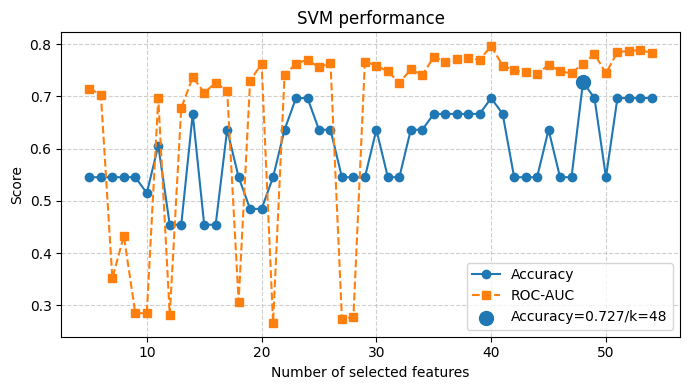


Accuracy = 0.727 | ROC-AUC = 0.763 | k = 48


In [15]:
ranking = shap_features

# Search spaces per kernel (lists => sampled uniformly)
search_spaces = [
    # linear
    {
        "kernel": ["linear"],
        "C": list(np.logspace(-3, 3, 200)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # rbf
    {
        "kernel": ["rbf"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # poly
    {
        "kernel": ["poly"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "degree": [2, 3, 4, 5],
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # sigmoid
    {
        "kernel": ["sigmoid"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
]

results = []
for k in range(5, 55):
    print(f"\n=== Testing top {k} features ===")
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    base = SVC(probability=True, random_state=42, cache_size=1000.0)

    search = RandomizedSearchCV(
        estimator=base,
        param_distributions=search_spaces,  # list of dicts => supports conditionals
        n_iter=80,
        scoring="roc_auc",  # align search with AUC
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0,
        error_score="raise",
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results, dtype=float)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, "o-", label="Accuracy")
plt.plot(feature_counts, auc_scores, "s--", label="ROC-AUC")
plt.scatter(
    best_k, best_acc, s=100, zorder=5, label=f"Accuracy={best_acc:.3f}/k={best_k}"
)
plt.title("SVM performance")
plt.xlabel("Number of selected features")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f} | ROC-AUC = {best_auc:.3f} | k = {best_k}")

## Model KBEST Features Tuning (Randomized Search CV)



=== Testing top 5 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0024420530945486497), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.04605922041145108), 'degree': 4, 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(202.55019392306664)}
Accuracy: 0.606 | ROC-AUC: 0.719

=== Testing top 6 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00016768329368110083), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.34891012134067734), 'degree': 3, 'coef0': np.float64(0.7000000000000001), 'class_weight': 'balanced', 'C': np.float64(0.2768286630392064)}
Accuracy: 0.545 | ROC-AUC: 0.667

=== Testing top 7 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00016768329368110083), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.34891012134067734), 'degree': 3, 'coef0': np.float64(0.7000000000000001), 'class_weight': 'balanced', 'C': np.float64(0.2768286630392064)}
Accuracy: 0.636 | ROC-AUC: 0.741

=== Testing top 8 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0009102981779915217), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.10353218432956626), 'degree': 4, 'coef0': np.float64(0.9500000000000001), 'class_weight': None, 'C': np.float64(4.150404757850472)}
Accuracy: 0.667 | ROC-AUC: 0.715

=== Testing top 9 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00016768329368110083), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.34891012134067734), 'degree': 3, 'coef0': np.float64(0.7000000000000001), 'class_weight': 'balanced', 'C': np.float64(0.2768286630392064)}
Accuracy: 0.697 | ROC-AUC: 0.767

=== Testing top 10 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.02899422853882878), 'degree': 5, 'coef0': np.float64(0.7000000000000001), 'class_weight': 'balanced', 'C': np.float64(10.96985797892384)}
Accuracy: 0.606 | ROC-AUC: 0.685

=== Testing top 11 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00010985411419875583), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.13049019780144028), 'degree': 3, 'coef0': np.float64(0.15000000000000002), 'class_weight': None, 'C': np.float64(2.381685551976158)}
Accuracy: 0.667 | ROC-AUC: 0.770

=== Testing top 12 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.02899422853882878), 'degree': 5, 'coef0': np.float64(0.7000000000000001), 'class_weight': 'balanced', 'C': np.float64(10.96985797892384)}
Accuracy: 0.606 | ROC-AUC: 0.719

=== Testing top 13 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(2.6826957952797274e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.02736439997074672), 'degree': 5, 'coef0': np.float64(0.7000000000000001), 'class_weight': 'balanced', 'C': np.float64(4.150404757850472)}
Accuracy: 0.515 | ROC-AUC: 0.707

=== Testing top 14 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(7.196856730011514e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.16446761779946645), 'degree': 5, 'coef0': np.float64(0.55), 'class_weight': 'balanced', 'C': np.float64(0.014992684327860455)}
Accuracy: 0.606 | ROC-AUC: 0.715

=== Testing top 15 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(2.6826957952797274e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.02736439997074672), 'degree': 5, 'coef0': np.float64(0.7000000000000001), 'class_weight': 'balanced', 'C': np.float64(4.150404757850472)}
Accuracy: 0.606 | ROC-AUC: 0.700

=== Testing top 16 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(2.6826957952797274e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.02736439997074672), 'degree': 5, 'coef0': np.float64(0.7000000000000001), 'class_weight': 'balanced', 'C': np.float64(4.150404757850472)}
Accuracy: 0.606 | ROC-AUC: 0.719

=== Testing top 17 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(2.6826957952797274e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.02736439997074672), 'degree': 5, 'coef0': np.float64(0.7000000000000001), 'class_weight': 'balanced', 'C': np.float64(4.150404757850472)}
Accuracy: 0.576 | ROC-AUC: 0.719

=== Testing top 18 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.005689866029018293), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.06517339604882427), 'degree': 5, 'coef0': np.float64(0.75), 'class_weight': 'balanced', 'C': np.float64(0.052310993080562605)}
Accuracy: 0.606 | ROC-AUC: 0.744

=== Testing top 19 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00022229964825261955), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 2, 'coef0': np.float64(1.0), 'class_weight': 'balanced', 'C': np.float64(0.17027691722258995)}
Accuracy: 0.545 | ROC-AUC: 0.670

=== Testing top 20 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00022229964825261955), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 2, 'coef0': np.float64(1.0), 'class_weight': 'balanced', 'C': np.float64(0.17027691722258995)}
Accuracy: 0.576 | ROC-AUC: 0.681

=== Testing top 21 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.004941713361323833), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.020490746898158482), 'degree': 5, 'coef0': np.float64(0.6000000000000001), 'class_weight': 'balanced', 'C': np.float64(0.7316807143427192)}
Accuracy: 0.606 | ROC-AUC: 0.711

=== Testing top 22 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.004941713361323833), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.020490746898158482), 'degree': 5, 'coef0': np.float64(0.6000000000000001), 'class_weight': 'balanced', 'C': np.float64(0.7316807143427192)}
Accuracy: 0.606 | ROC-AUC: 0.704

=== Testing top 23 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.004941713361323833), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.020490746898158482), 'degree': 5, 'coef0': np.float64(0.6000000000000001), 'class_weight': 'balanced', 'C': np.float64(0.7316807143427192)}
Accuracy: 0.606 | ROC-AUC: 0.689

=== Testing top 24 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0003906939937054617), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.05170920242896761), 'degree': 2, 'coef0': np.float64(0.7000000000000001), 'class_weight': None, 'C': np.float64(0.0016257556664437934)}
Accuracy: 0.545 | ROC-AUC: 0.756

=== Testing top 25 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(1.5264179671752335e-05), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.1096985797892384), 'degree': 3, 'coef0': np.float64(0.7000000000000001), 'class_weight': None, 'C': np.float64(0.001320088400831418)}
Accuracy: 0.667 | ROC-AUC: 0.763

=== Testing top 26 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0032374575428176433), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.005415871378079476), 'degree': 5, 'coef0': np.float64(0.35000000000000003), 'class_weight': None, 'C': np.float64(0.419870708444391)}
Accuracy: 0.545 | ROC-AUC: 0.765

=== Testing top 27 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0032374575428176433), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.005415871378079476), 'degree': 5, 'coef0': np.float64(0.35000000000000003), 'class_weight': None, 'C': np.float64(0.419870708444391)}
Accuracy: 0.545 | ROC-AUC: 0.759

=== Testing top 28 features ===
Best parameters: {'tol': np.float64(7.196856730011514e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.006080224261649427), 'degree': 5, 'coef0': np.float64(0.15000000000000002), 'class_weight': None, 'C': np.float64(0.03001835813575589)}
Accuracy: 0.545 | ROC-AUC: 0.763

=== Testing top 29 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.606 | ROC-AUC: 0.748

=== Testing top 30 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(7.196856730011514e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.006080224261649427), 'degree': 5, 'coef0': np.float64(0.15000000000000002), 'class_weight': None, 'C': np.float64(0.03001835813575589)}
Accuracy: 0.545 | ROC-AUC: 0.222

=== Testing top 31 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.606 | ROC-AUC: 0.774

=== Testing top 32 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.606 | ROC-AUC: 0.785

=== Testing top 33 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.606 | ROC-AUC: 0.789

=== Testing top 34 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.606 | ROC-AUC: 0.791

=== Testing top 35 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.606 | ROC-AUC: 0.789

=== Testing top 36 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.606 | ROC-AUC: 0.789

=== Testing top 37 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.606 | ROC-AUC: 0.789

=== Testing top 38 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.606 | ROC-AUC: 0.811

=== Testing top 39 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.606 | ROC-AUC: 0.831

=== Testing top 40 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.667 | ROC-AUC: 0.819

=== Testing top 41 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.697 | ROC-AUC: 0.830

=== Testing top 42 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.727 | ROC-AUC: 0.819

=== Testing top 43 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.697 | ROC-AUC: 0.820

=== Testing top 44 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.727 | ROC-AUC: 0.820

=== Testing top 45 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.697 | ROC-AUC: 0.817

=== Testing top 46 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.727 | ROC-AUC: 0.798

=== Testing top 47 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.697 | ROC-AUC: 0.815

=== Testing top 48 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.697 | ROC-AUC: 0.794

=== Testing top 49 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.697 | ROC-AUC: 0.793

=== Testing top 50 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.727 | ROC-AUC: 0.796

=== Testing top 51 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.727 | ROC-AUC: 0.800

=== Testing top 52 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.727 | ROC-AUC: 0.780

=== Testing top 53 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.727 | ROC-AUC: 0.778

=== Testing top 54 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.697 | ROC-AUC: 0.800


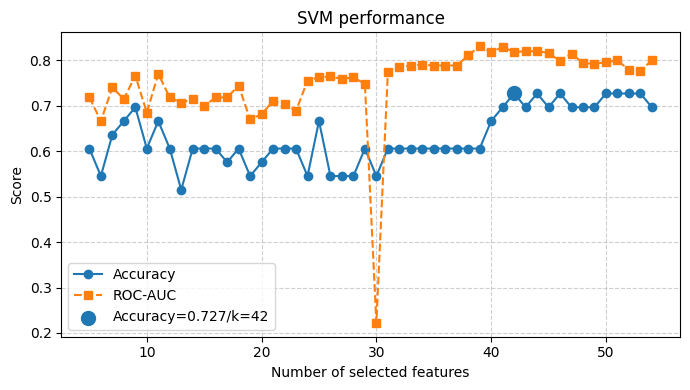


Accuracy = 0.727 | ROC-AUC = 0.819 | k = 42


In [16]:
ranking = kbest_features

# Search spaces per kernel (lists => sampled uniformly)
search_spaces = [
    # linear
    {
        "kernel": ["linear"],
        "C": list(np.logspace(-3, 3, 200)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # rbf
    {
        "kernel": ["rbf"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # poly
    {
        "kernel": ["poly"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "degree": [2, 3, 4, 5],
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # sigmoid
    {
        "kernel": ["sigmoid"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
]

results = []
for k in range(5, 55):
    print(f"\n=== Testing top {k} features ===")
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    base = SVC(probability=True, random_state=42, cache_size=1000.0)

    search = RandomizedSearchCV(
        estimator=base,
        param_distributions=search_spaces,  # list of dicts => supports conditionals
        n_iter=80,
        scoring="roc_auc",  # align search with AUC
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0,
        error_score="raise",
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results, dtype=float)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, "o-", label="Accuracy")
plt.plot(feature_counts, auc_scores, "s--", label="ROC-AUC")
plt.scatter(
    best_k, best_acc, s=100, zorder=5, label=f"Accuracy={best_acc:.3f}/k={best_k}"
)
plt.title("SVM performance")
plt.xlabel("Number of selected features")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f} | ROC-AUC = {best_auc:.3f} | k = {best_k}")

## Model LASSO Features Tuning (Randomized Search CV)



=== Testing top 5 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00010985411419875583), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.13049019780144028), 'degree': 3, 'coef0': np.float64(0.15000000000000002), 'class_weight': None, 'C': np.float64(2.381685551976158)}
Accuracy: 0.636 | ROC-AUC: 0.670

=== Testing top 6 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.004291934260128779), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.05170920242896761), 'degree': 3, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(535.3566677410719)}
Accuracy: 0.606 | ROC-AUC: 0.659

=== Testing top 7 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.697 | ROC-AUC: 0.733

=== Testing top 8 features ===
Best parameters: {'tol': np.float64(0.00022229964825261955), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.0028660676169482502), 'degree': 3, 'coef0': np.float64(0.8), 'class_weight': None, 'C': np.float64(14.48118227674533)}
Accuracy: 0.697 | ROC-AUC: 0.781

=== Testing top 9 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.727 | ROC-AUC: 0.704

=== Testing top 10 features ===
Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.697 | ROC-AUC: 0.696

=== Testing top 11 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.727 | ROC-AUC: 0.715

=== Testing top 12 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.697 | ROC-AUC: 0.770

=== Testing top 13 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.667 | ROC-AUC: 0.711

=== Testing top 14 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.606 | ROC-AUC: 0.689

=== Testing top 15 features ===
Best parameters: {'tol': np.float64(0.0024420530945486497), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.04605922041145108), 'degree': 4, 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(202.55019392306664)}
Accuracy: 0.515 | ROC-AUC: 0.581

=== Testing top 16 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.727 | ROC-AUC: 0.759

=== Testing top 17 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.636 | ROC-AUC: 0.733

=== Testing top 18 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.697 | ROC-AUC: 0.730

=== Testing top 19 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.727 | ROC-AUC: 0.752

=== Testing top 20 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.697 | ROC-AUC: 0.730

=== Testing top 21 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.606 | ROC-AUC: 0.693

=== Testing top 22 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.636 | ROC-AUC: 0.656

=== Testing top 23 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.606 | ROC-AUC: 0.681

=== Testing top 24 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.606 | ROC-AUC: 0.689

=== Testing top 25 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.667 | ROC-AUC: 0.689

=== Testing top 26 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.636 | ROC-AUC: 0.689

=== Testing top 27 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.636 | ROC-AUC: 0.696

=== Testing top 28 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.636 | ROC-AUC: 0.678

=== Testing top 29 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.606 | ROC-AUC: 0.681

=== Testing top 30 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.606 | ROC-AUC: 0.656

=== Testing top 31 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.606 | ROC-AUC: 0.667

=== Testing top 32 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.636 | ROC-AUC: 0.670

=== Testing top 33 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.606 | ROC-AUC: 0.663

=== Testing top 34 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.636 | ROC-AUC: 0.674

=== Testing top 35 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.636 | ROC-AUC: 0.659

=== Testing top 36 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.667 | ROC-AUC: 0.707

=== Testing top 37 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.667 | ROC-AUC: 0.674

=== Testing top 38 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.606 | ROC-AUC: 0.689

=== Testing top 39 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.636 | ROC-AUC: 0.726

=== Testing top 40 features ===
Best parameters: {'tol': np.float64(0.004291934260128779), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.05170920242896761), 'degree': 3, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(535.3566677410719)}
Accuracy: 0.788 | ROC-AUC: 0.844

=== Testing top 41 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.004291934260128779), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.05170920242896761), 'degree': 3, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(535.3566677410719)}
Accuracy: 0.788 | ROC-AUC: 0.837

=== Testing top 42 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.000339322177189533), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(3.7399373024788014), 'degree': 3, 'coef0': np.float64(0.7000000000000001), 'class_weight': None, 'C': np.float64(434.7013158125018)}
Accuracy: 0.697 | ROC-AUC: 0.837

=== Testing top 43 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(8.286427728546843e-05), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.0690551352016233), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(28.99422853882875)}
Accuracy: 0.667 | ROC-AUC: 0.748

=== Testing top 44 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0005179474679231213), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(8.406652885618334), 'degree': 3, 'coef0': np.float64(0.8500000000000001), 'class_weight': None, 'C': np.float64(0.07934096665797492)}
Accuracy: 0.758 | ROC-AUC: 0.826

=== Testing top 45 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(8.286427728546843e-05), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.0690551352016233), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(28.99422853882875)}
Accuracy: 0.697 | ROC-AUC: 0.767

=== Testing top 46 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.333

=== Testing top 47 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.678

=== Testing top 48 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(9.999999999999999e-06), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.27682866303920667), 'degree': 5, 'coef0': np.float64(0.8500000000000001), 'class_weight': None, 'C': np.float64(0.07934096665797492)}
Accuracy: 0.636 | ROC-AUC: 0.815

=== Testing top 49 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0004498432668969444), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.2072921779595372), 'degree': 5, 'coef0': np.float64(0.65), 'class_weight': 'balanced', 'C': np.float64(0.01135733358343105)}
Accuracy: 0.636 | ROC-AUC: 0.774

=== Testing top 50 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.005689866029018293), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.2612675225563329), 'degree': 5, 'coef0': np.float64(0.65), 'class_weight': None, 'C': np.float64(0.36543830709572545)}
Accuracy: 0.667 | ROC-AUC: 0.828

=== Testing top 51 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.681

=== Testing top 52 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0009102981779915217), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.10353218432956626), 'degree': 4, 'coef0': np.float64(0.9500000000000001), 'class_weight': None, 'C': np.float64(4.150404757850472)}
Accuracy: 0.636 | ROC-AUC: 0.744

=== Testing top 53 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(8.286427728546843e-05), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.0690551352016233), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(28.99422853882875)}
Accuracy: 0.636 | ROC-AUC: 0.748

=== Testing top 54 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(8.286427728546843e-05), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.0690551352016233), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(28.99422853882875)}
Accuracy: 0.636 | ROC-AUC: 0.744


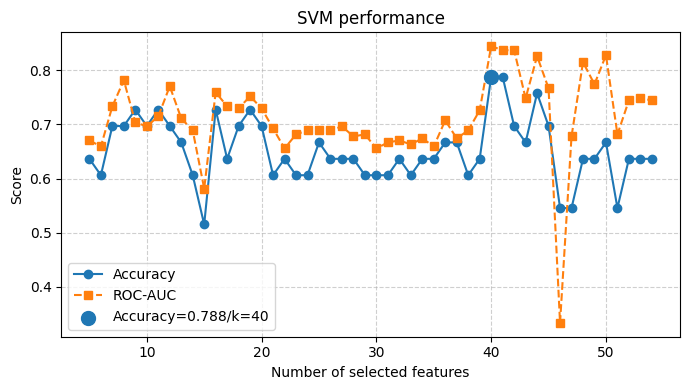


Accuracy = 0.788 | ROC-AUC = 0.844 | k = 40


In [17]:
ranking = lasso_features

# Search spaces per kernel (lists => sampled uniformly)
search_spaces = [
    # linear
    {
        "kernel": ["linear"],
        "C": list(np.logspace(-3, 3, 200)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # rbf
    {
        "kernel": ["rbf"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # poly
    {
        "kernel": ["poly"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "degree": [2, 3, 4, 5],
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # sigmoid
    {
        "kernel": ["sigmoid"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
]

results = []
for k in range(5, 55):
    print(f"\n=== Testing top {k} features ===")
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    base = SVC(probability=True, random_state=42, cache_size=1000.0)

    search = RandomizedSearchCV(
        estimator=base,
        param_distributions=search_spaces,  # list of dicts => supports conditionals
        n_iter=80,
        scoring="roc_auc",  # align search with AUC
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0,
        error_score="raise",
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results, dtype=float)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, "o-", label="Accuracy")
plt.plot(feature_counts, auc_scores, "s--", label="ROC-AUC")
plt.scatter(
    best_k, best_acc, s=100, zorder=5, label=f"Accuracy={best_acc:.3f}/k={best_k}"
)
plt.title("SVM performance")
plt.xlabel("Number of selected features")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f} | ROC-AUC = {best_auc:.3f} | k = {best_k}")